[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/new_notebook.ipynb)

In [6]:
try:
    import google.colab 
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


## 1. Librerias y configuraciones previas

In [2]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [42]:
import os
import re
import pandas as pd
import seaborn as sns

* jsonfile = open("local/data/emp1.json", "w")
* jsonfile.write(emp1_str)
* jsonfile.close()

### 2. Carga del dataset

Carga y combinación de los datos en un solo dataframe

In [9]:
def load_and_merge_csv(directory_path):
    """
    Carga todos los archivos CSV de un directorio, extrae un número identificador del nombre de archivo
    y concatena todos los datos en un único DataFrame con una columna adicional 'file_id'.

    Parámetros:
        directory_path (str): Ruta al directorio que contiene los archivos CSV.

    Retorna:
        pd.DataFrame: DataFrame con los datos combinados y columna 'file_id'.

    Requisitos:
        Los arhivos tienen la forma subject_1_features.csv, subject_2_features.csv, etc.
    """
    all_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    merged_data = []

    for file in all_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)

        # Extrae el primer número del nombre del archivo (puedes ajustar la expresión regular si es necesario)
        match = re.search(r'\d+', file)
        file_id = int(match.group()) if match else None

        df['subject'] = file_id
        merged_data.append(df)

    return pd.concat(merged_data, ignore_index=True)

El dataframe en el que se combinaron los datos fue: `merged_df` 

In [10]:
# Specify the directory path
directory_path = './local/data'

# Load and merge CSV files
merged_df = load_and_merge_csv(directory_path)

In [11]:
# Display the first few rows of the merged DataFrame
merged_df.shape

(21594, 42)

In [12]:
# Display the first few rows of the merged DataFrame
merged_df.head()

,RMS_f0,RMS_f1,RMS_f2,RMS_f3,RMS_f4,RMS_f5,RMS_f6,RMS_f7,RMS_f8,RMS_f9,...,SSC_f2,SSC_f3,SSC_f4,SSC_f5,SSC_f6,SSC_f7,SSC_f8,SSC_f9,restimulus,subject
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,10
2,0.214203,0.027382,0.070140,0.002309,0.002581,0.005600,0.146619,0.526502,0.002533,0.311813,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,10
3,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10
4,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,10


Ahora se divide el dataframe en un diccionario de dataframes por caracteristicas

In [13]:
def split_features_by_type(df):
    """
    Divide un DataFrame en un diccionario donde las claves son las características
    encontradas en los nombres de las columnas y los valores son DataFrames
    con las columnas correspondientes a esa característica, incluyendo las columnas
    'restimulus' y 'subject'.

    Parámetros:
        df (pd.DataFrame): DataFrame con todas las características.

    Retorna:
        dict: Diccionario con claves como nombres de características (e.g., 'RMS', 'MAV')
              y valores como DataFrames con las columnas correspondientes.
    """
    feature_dict = {}
    for column in df.columns:
        # Extraer el prefijo de la característica (e.g., 'RMS', 'MAV', etc.)
        match = re.match(r'([A-Z]+)_', column)
        if match:
            feature_type = match.group(1)
            if feature_type not in feature_dict:
                feature_dict[feature_type] = []
            feature_dict[feature_type].append(column)
    
    # Convertir las listas de columnas en DataFrames e incluir 'restimulus' y 'subject'
    for feature_type in feature_dict:
        feature_dict[feature_type] = df[feature_dict[feature_type] + ['restimulus', 'subject']]
    
    return feature_dict

El diccionario con las caracteristicas se va a llamar `features_dict`:

In [15]:
# Dividir las características por tipo
features_dict = split_features_by_type(merged_df)

In [16]:
features_dict.keys()

dict_keys(['RMS', 'MAV', 'ZC', 'SSC'])

In [17]:
features_dict['RMS'].head()

,RMS_f0,RMS_f1,RMS_f2,RMS_f3,RMS_f4,RMS_f5,RMS_f6,RMS_f7,RMS_f8,RMS_f9,restimulus,subject
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0,10
2,0.214203,0.027382,0.070140,0.002309,0.002581,0.005600,0.146619,0.526502,0.002533,0.311813,-1.0,10
3,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0,10
4,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0,10


In [18]:
features_dict['MAV'].head()

,MAV_f0,MAV_f1,MAV_f2,MAV_f3,MAV_f4,MAV_f5,MAV_f6,MAV_f7,MAV_f8,MAV_f9,restimulus,subject
0,0.183693,0.060620,0.007765,0.002369,0.002316,0.002333,0.008609,0.023143,0.002157,0.020405,0.0,10
1,0.147227,0.021864,0.009099,0.002311,0.002293,0.003275,0.052383,0.127750,0.001953,0.055653,0.0,10
2,0.207631,0.024446,0.057055,0.002309,0.002569,0.005478,0.140409,0.486567,0.002465,0.277829,-1.0,10
3,0.385928,0.071161,0.184839,0.002645,0.003640,0.007516,0.218086,0.926799,0.005241,0.639306,1.0,10
4,0.652486,0.137464,0.332023,0.003689,0.005926,0.008054,0.247321,1.143647,0.010746,0.944538,1.0,10


Se agrega para las columnas `restimulus` y `subject` las respectivas columnas asociadas a la categoria.

In [21]:
for feature_type, df in features_dict.items():
    df.loc[:, 'restimulus_cat'] = df['restimulus'].astype('category')
    df.loc[:, 'subject_cat'] = df['subject'].astype('category')

In [23]:
features_dict['RMS'].head()

,RMS_f0,RMS_f1,RMS_f2,RMS_f3,RMS_f4,RMS_f5,RMS_f6,RMS_f7,RMS_f8,RMS_f9,restimulus,subject,restimulus_cat,subject_cat
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0,10,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0,10,0.0,10
2,0.214203,0.027382,0.070140,0.002309,0.002581,0.005600,0.146619,0.526502,0.002533,0.311813,-1.0,10,-1.0,10
3,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0,10,1.0,10
4,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0,10,1.0,10


### 3. EDA simple

#### 3.1. RMS

In [27]:
rms_df = features_dict['RMS']

##### Inspección Inicial del Dataset

* Dimensiones del DataFrame

In [28]:
rms_df.shape

(21594, 14)

* Tipos de datos

In [30]:
rms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21594 entries, 0 to 21593
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   RMS_f0          21594 non-null  float64 
 1   RMS_f1          21594 non-null  float64 
 2   RMS_f2          21594 non-null  float64 
 3   RMS_f3          21594 non-null  float64 
 4   RMS_f4          21594 non-null  float64 
 5   RMS_f5          21594 non-null  float64 
 6   RMS_f6          21594 non-null  float64 
 7   RMS_f7          21594 non-null  float64 
 8   RMS_f8          21594 non-null  float64 
 9   RMS_f9          21594 non-null  float64 
 10  restimulus      21594 non-null  float64 
 11  subject         21594 non-null  int64   
 12  restimulus_cat  21594 non-null  category
 13  subject_cat     21594 non-null  category
dtypes: category(2), float64(11), int64(1)
memory usage: 2.0 MB


* Valores nulos

In [31]:
rms_df.isnull().sum()

RMS_f0            0
RMS_f1            0
RMS_f2            0
RMS_f3            0
RMS_f4            0
RMS_f5            0
RMS_f6            0
RMS_f7            0
RMS_f8            0
RMS_f9            0
restimulus        0
subject           0
restimulus_cat    0
subject_cat       0
dtype: int64

* Estadísticas descriptivas

In [34]:
rms_columns = [col for col in rms_df.columns if "RMS" in col]
rms_df[rms_columns].describe()

,RMS_f0,RMS_f1,RMS_f2,RMS_f3,RMS_f4,RMS_f5,RMS_f6,RMS_f7,RMS_f8,RMS_f9
count,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000
mean,0.327002,0.189303,0.150283,0.070692,0.033849,0.109544,0.387434,0.482573,0.152121,0.255340
std,0.467080,0.288337,0.253705,0.189489,0.067859,0.250088,0.535453,0.552697,0.270926,0.375481
min,0.000374,0.000323,0.000315,0.000333,0.000326,0.000406,0.000361,0.000451,0.000340,0.000273
25%,0.007035,0.003387,0.002692,0.002428,0.002522,0.004134,0.052696,0.085096,0.002606,0.039387
50%,0.104249,0.060505,0.023528,0.004073,0.004685,0.032083,0.187517,0.277685,0.034917,0.139191
75%,0.472926,0.277147,0.196554,0.059696,0.032870,0.108196,0.504527,0.706979,0.189169,0.315512
max,3.608882,4.247692,2.656120,3.393174,0.809771,3.264254,4.705026,4.359882,3.207452,4.230890


#### Analisis univariado

##### Variables numericas

* Histogramas

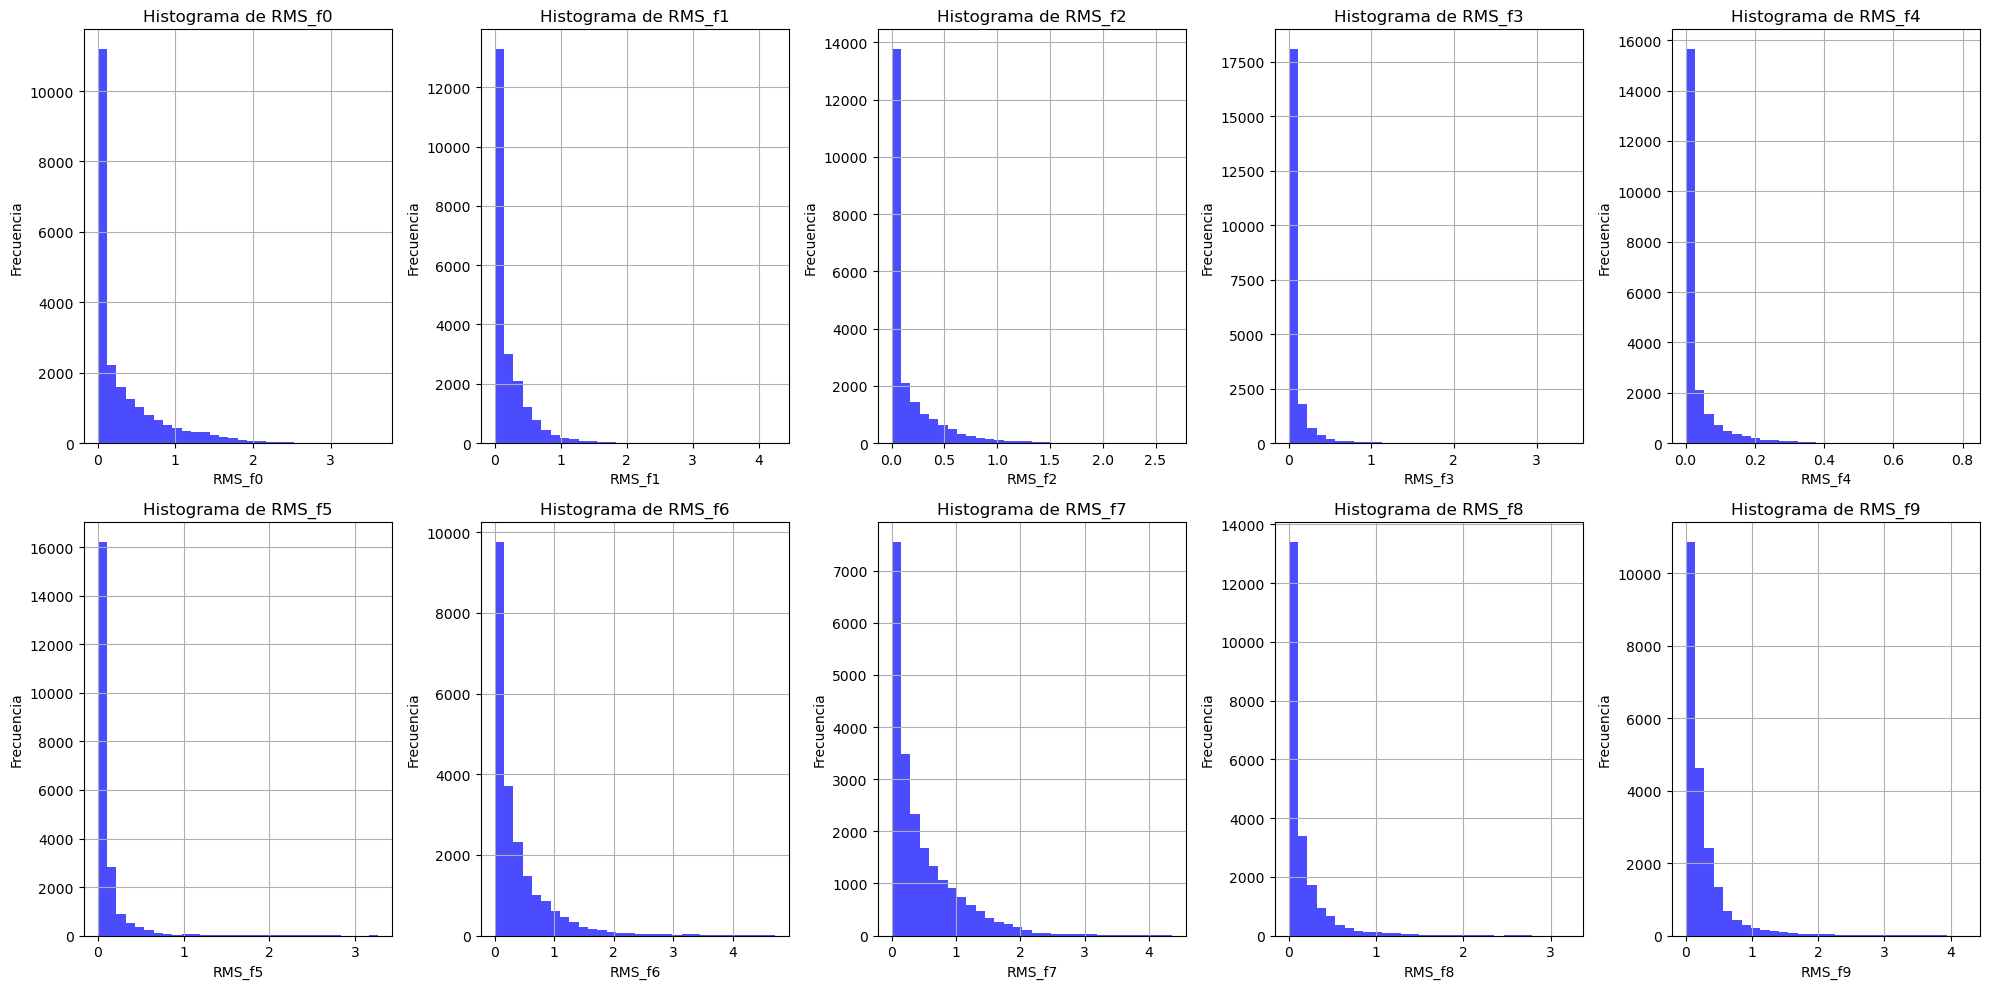

In [35]:
import matplotlib.pyplot as plt

# Crear una figura y subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 2 filas y 5 columnas para 10 columnas en total
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar un histograma para cada columna
for i, col in enumerate(rms_columns):
    rms_df[col].hist(ax=axes[i], bins=30, alpha=0.7, color='blue')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ajustar el diseño
plt.tight_layout()
plt.show()

* Diagramas de cajas y bigotes

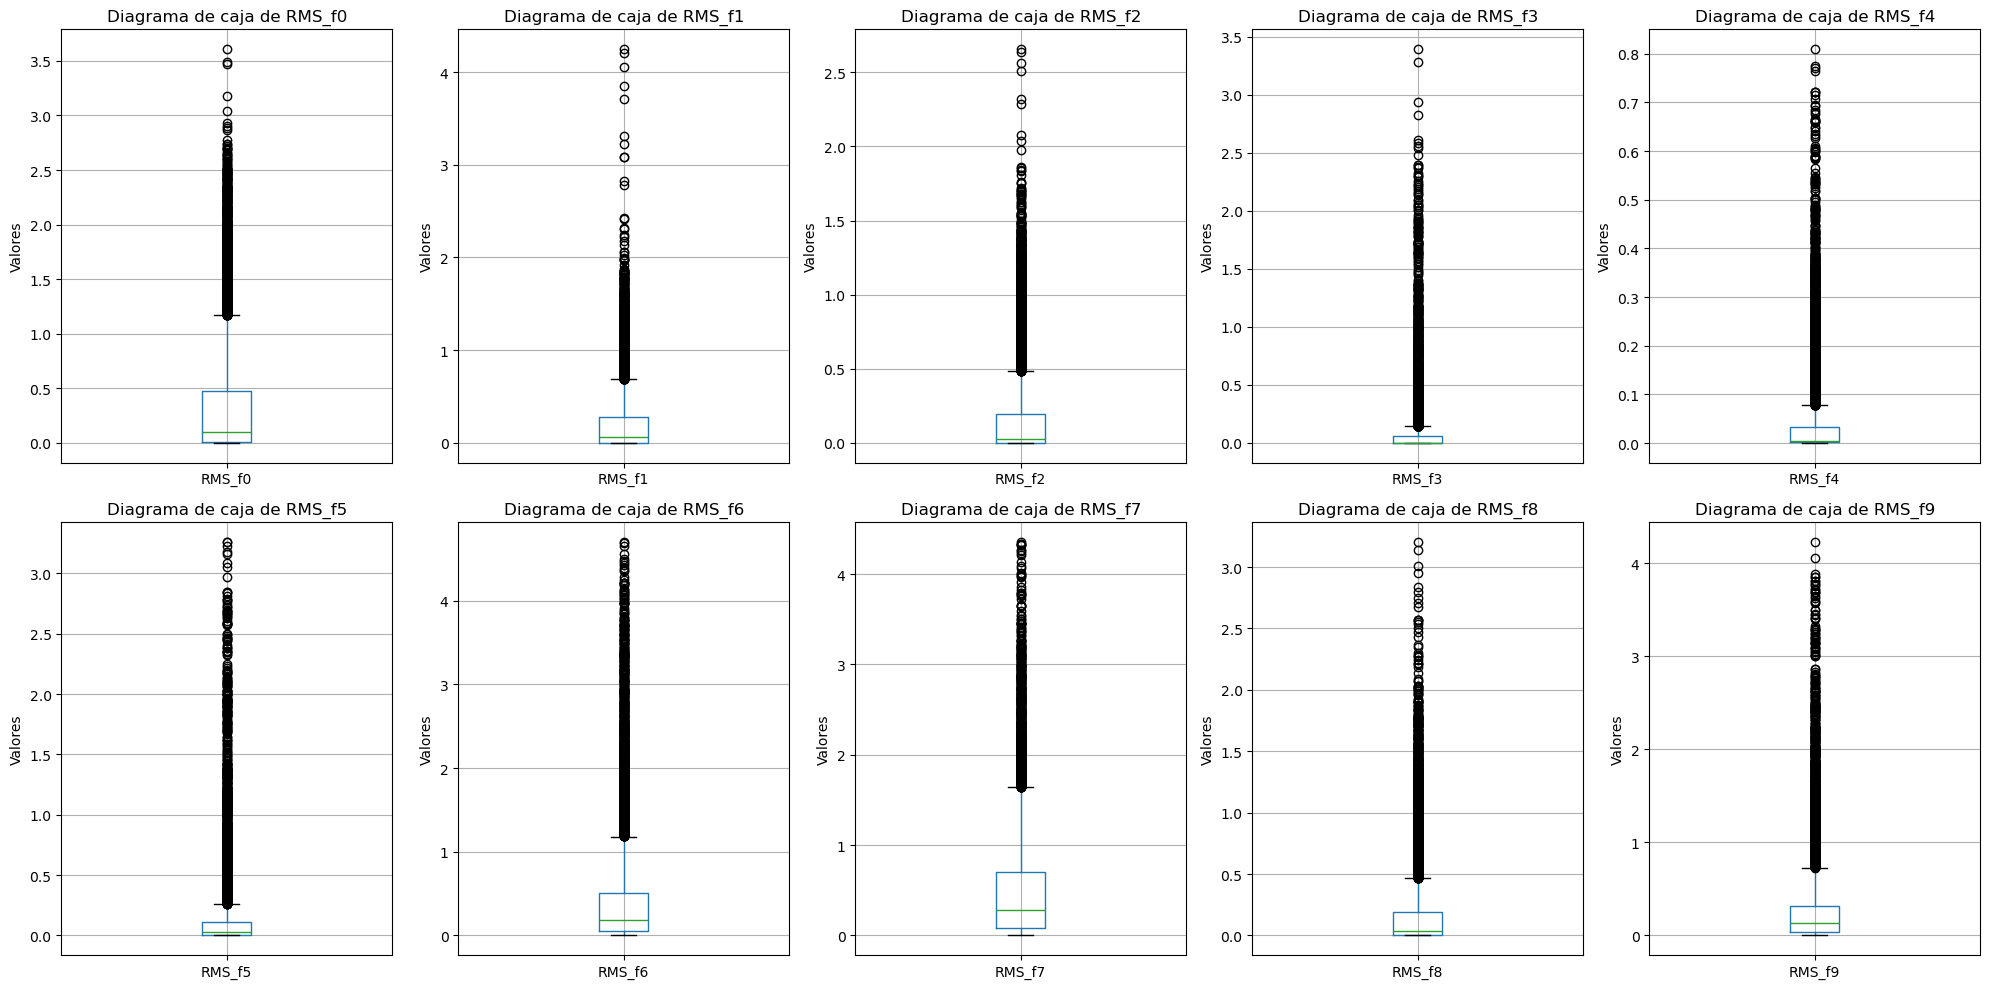

In [36]:
# Crear una figura y subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 2 filas y 5 columnas para 10 columnas en total
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar un diagrama de caja para cada columna
for i, col in enumerate(rms_columns):
    rms_df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Diagrama de caja de {col}')
    axes[i].set_ylabel('Valores')

# Ajustar el diseño
plt.tight_layout()
plt.show()

* Asimetria y curtosis

In [37]:
# Calcular asimetría y curtosis para las columnas RMS
asimetria = rms_df[rms_columns].skew()
curtosis = rms_df[rms_columns].kurt()

# Mostrar los resultados
print("Asimetría:")
print(asimetria)
print("\nCurtosis:")
print(curtosis)

Asimetría:
RMS_f0    1.964285
RMS_f1    2.981277
RMS_f2    2.627824
RMS_f3    6.596876
RMS_f4    4.058238
RMS_f5    5.849546
RMS_f6    2.936527
RMS_f7    1.984222
RMS_f8    3.614030
RMS_f9    3.806407
dtype: float64

Curtosis:
RMS_f0     4.028442
RMS_f1    16.272895
RMS_f2     8.921317
RMS_f3    60.747654
RMS_f4    23.019549
RMS_f5    45.000376
RMS_f6    11.989366
RMS_f7     5.374856
RMS_f8    18.359057
RMS_f9    21.009009
dtype: float64


##### Variables categoricas

* Frecuencia de categorías

Para el caso solo nos vamos a centrar en las categorias asociadas a la postura.

In [39]:
# Frecuencia de categorías en 'restimulus_cat'
restimulus_freq = rms_df['restimulus_cat'].value_counts()
print("Frecuencia de categorías en 'restimulus_cat':")
print(restimulus_freq)

Frecuencia de categorías en 'restimulus_cat':
restimulus_cat
 0.0     9809
 23.0    5810
 1.0     4424
-1.0     1551
Name: count, dtype: int64


* Gráficos de barras

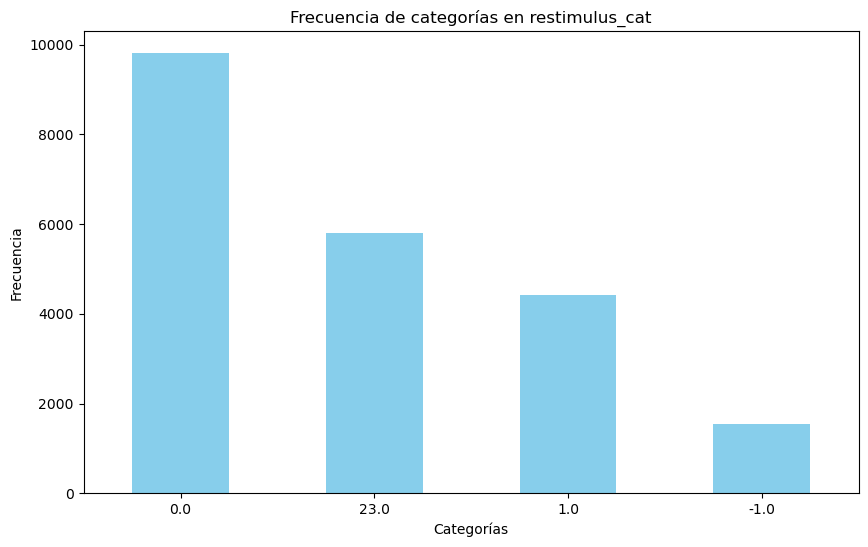

In [40]:
# Crear un gráfico de barras para las frecuencias de 'restimulus_cat'
restimulus_freq.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Frecuencia de categorías en restimulus_cat')
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

Vemos que los datos se encuentran desbalanceados.

> [!WARNING]  
> * ¿Sera el usar labels -1 para las ventana de transición causa un impacto en los resultados?
> * ¿Tienen sentido esta cantidad de warnings? 

##### Analisis bivariado

**Numerico .vs. numerico**

* Matriz de correlación

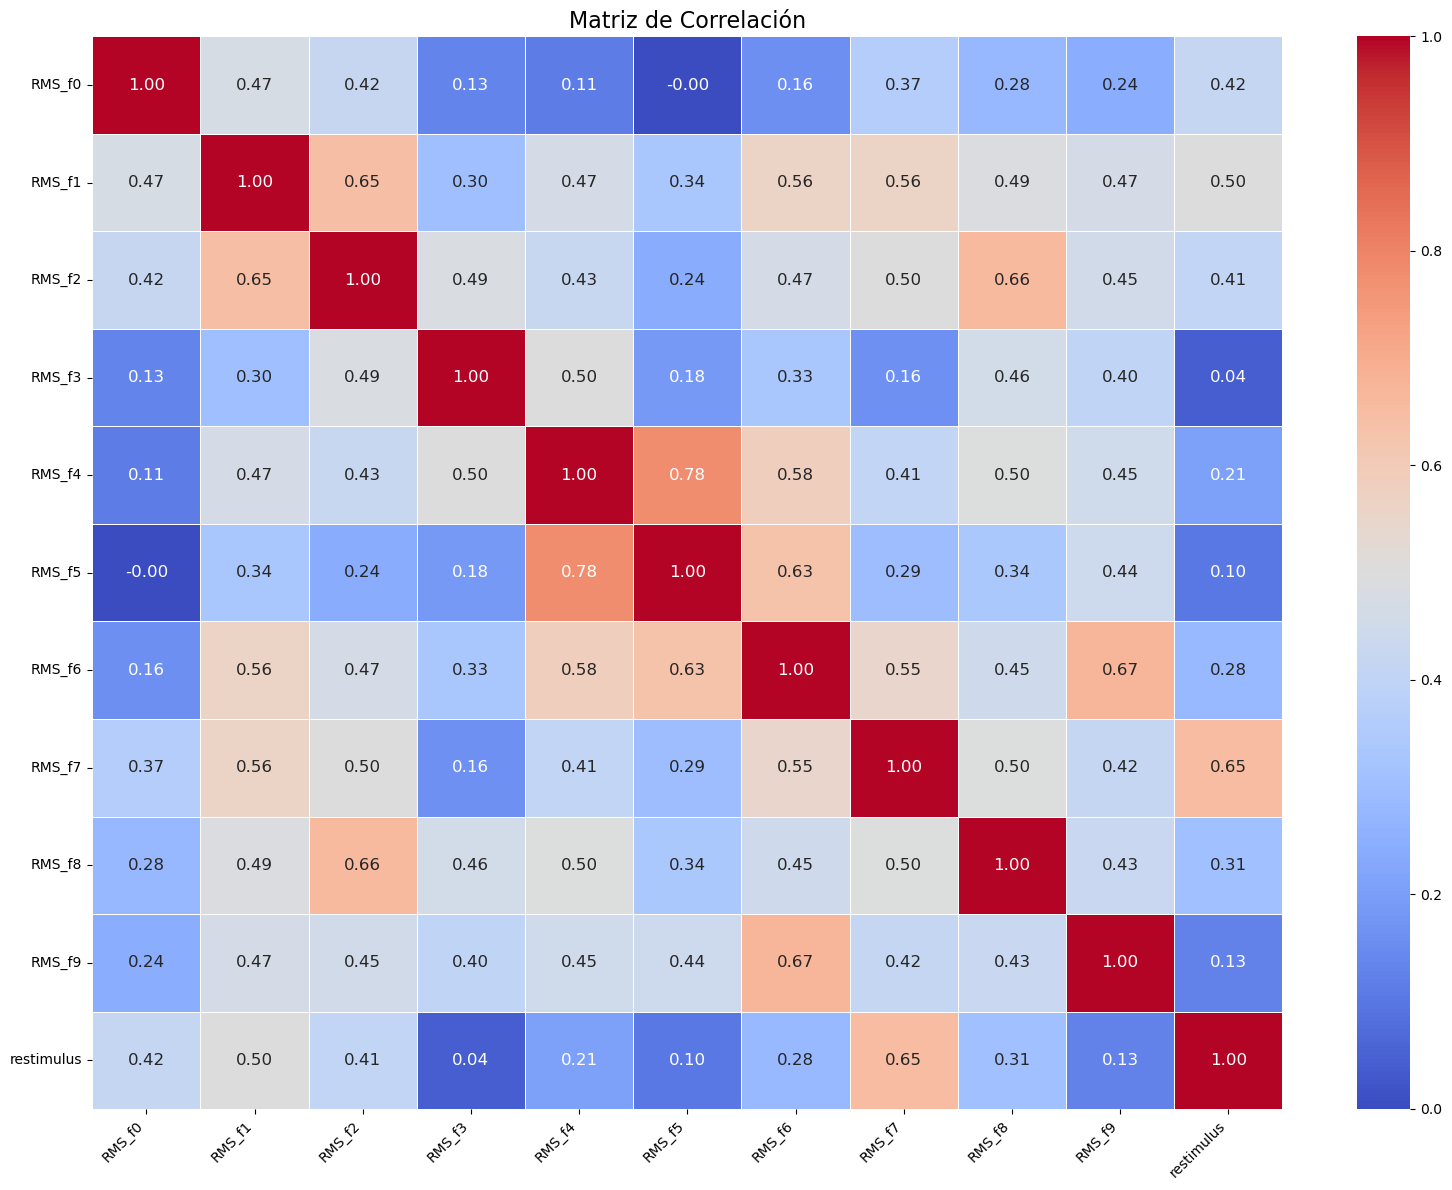

In [45]:
# Calcular la matriz de correlación
corr = rms_df[rms_columns + ['restimulus']].corr()

# Establecer el tamaño de la figura y la resolución
plt.figure(figsize=(16, 12), dpi=100)

# Crear el mapa de calor con anotaciones más grandes y líneas divisorias
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"size": 12},
    linewidths=0.5,
    linecolor='white'
)

# Ajustar las etiquetas de los ejes para mejorar la legibilidad
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Establecer el título del mapa de calor
plt.title("Matriz de Correlación", fontsize=16)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


* Diagramas de dispersión (Scatter plots)

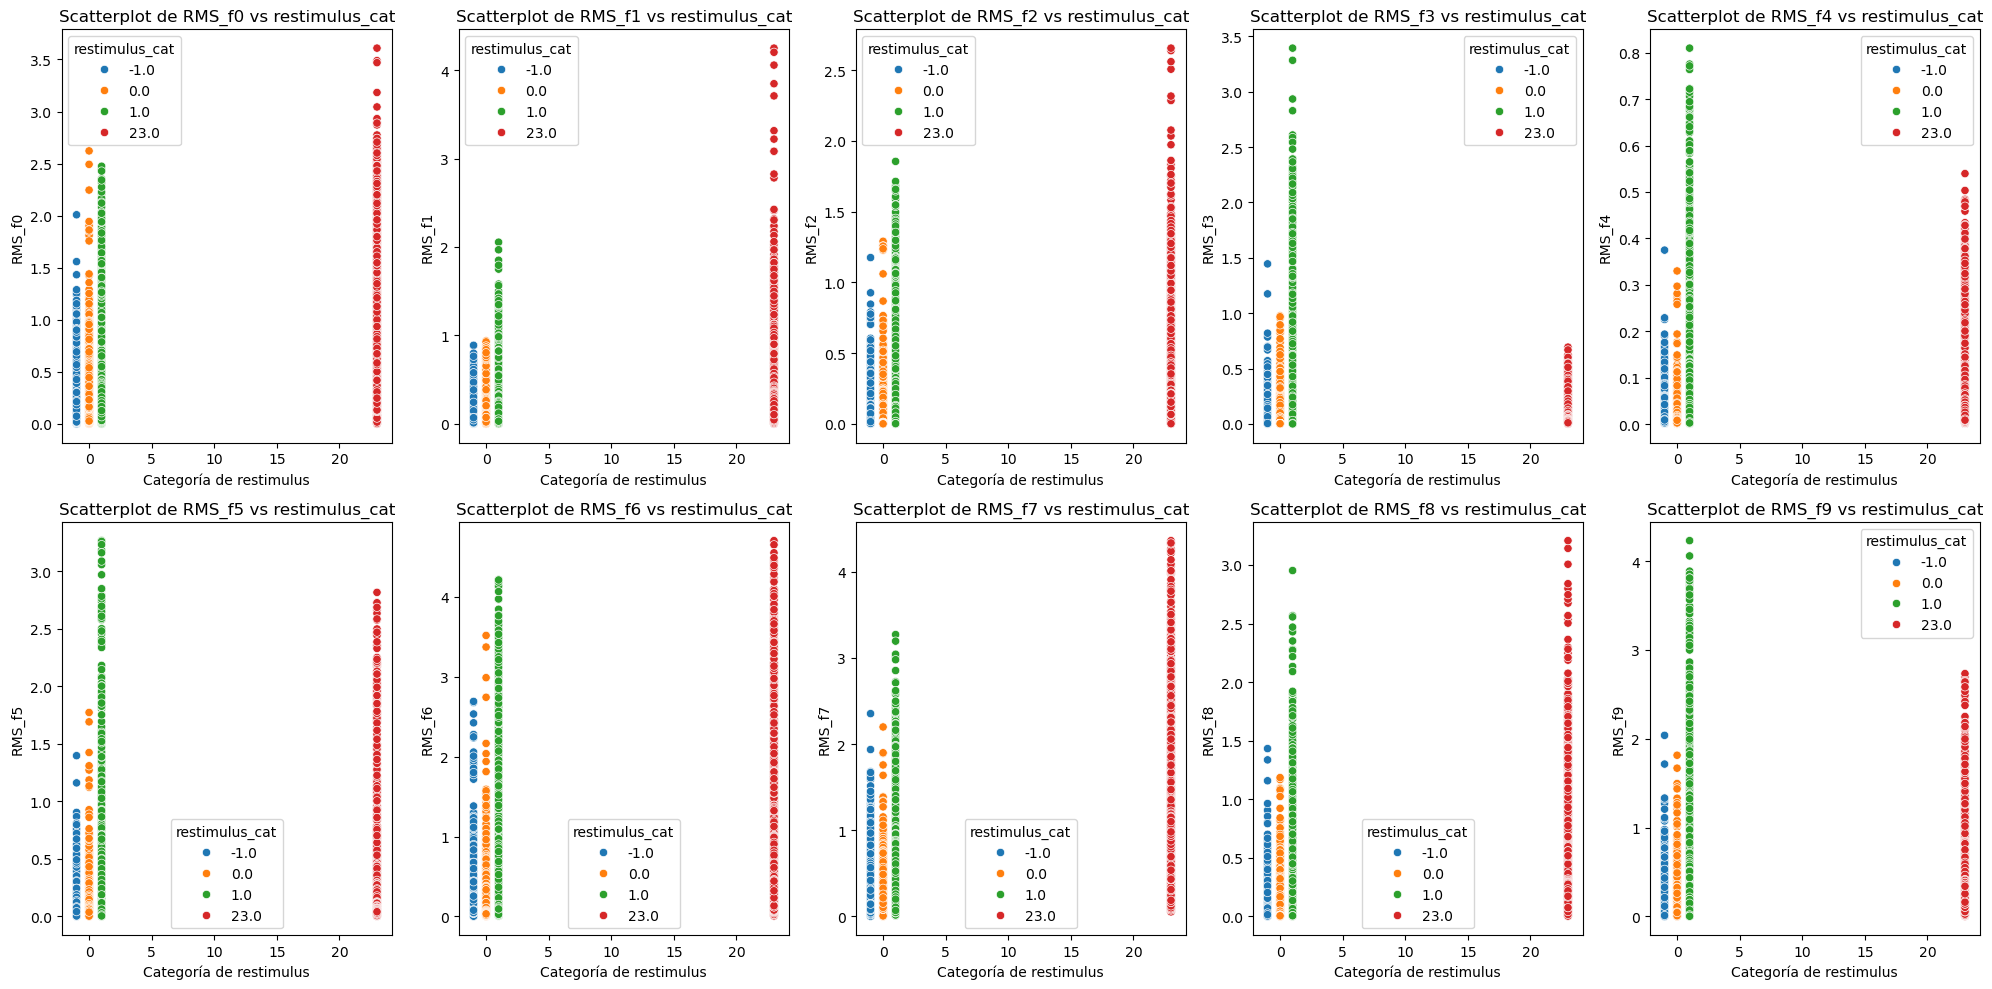

In [49]:
# Crear una figura y subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 2 filas y 5 columnas para 10 columnas en total
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar un scatterplot para cada columna EMG
for i, col in enumerate(rms_columns):
    sns.scatterplot(x='restimulus_cat', y=col, data=rms_df, ax=axes[i], hue='restimulus_cat', palette='tab10', legend=True)
    axes[i].set_title(f'Scatterplot de {col} vs restimulus_cat')
    axes[i].set_xlabel('Categoría de restimulus')
    axes[i].set_ylabel(col)

# Ajustar el diseño
plt.tight_layout()
plt.show()

**Categórico vs. Numérico**

* Boxplots por categoría:

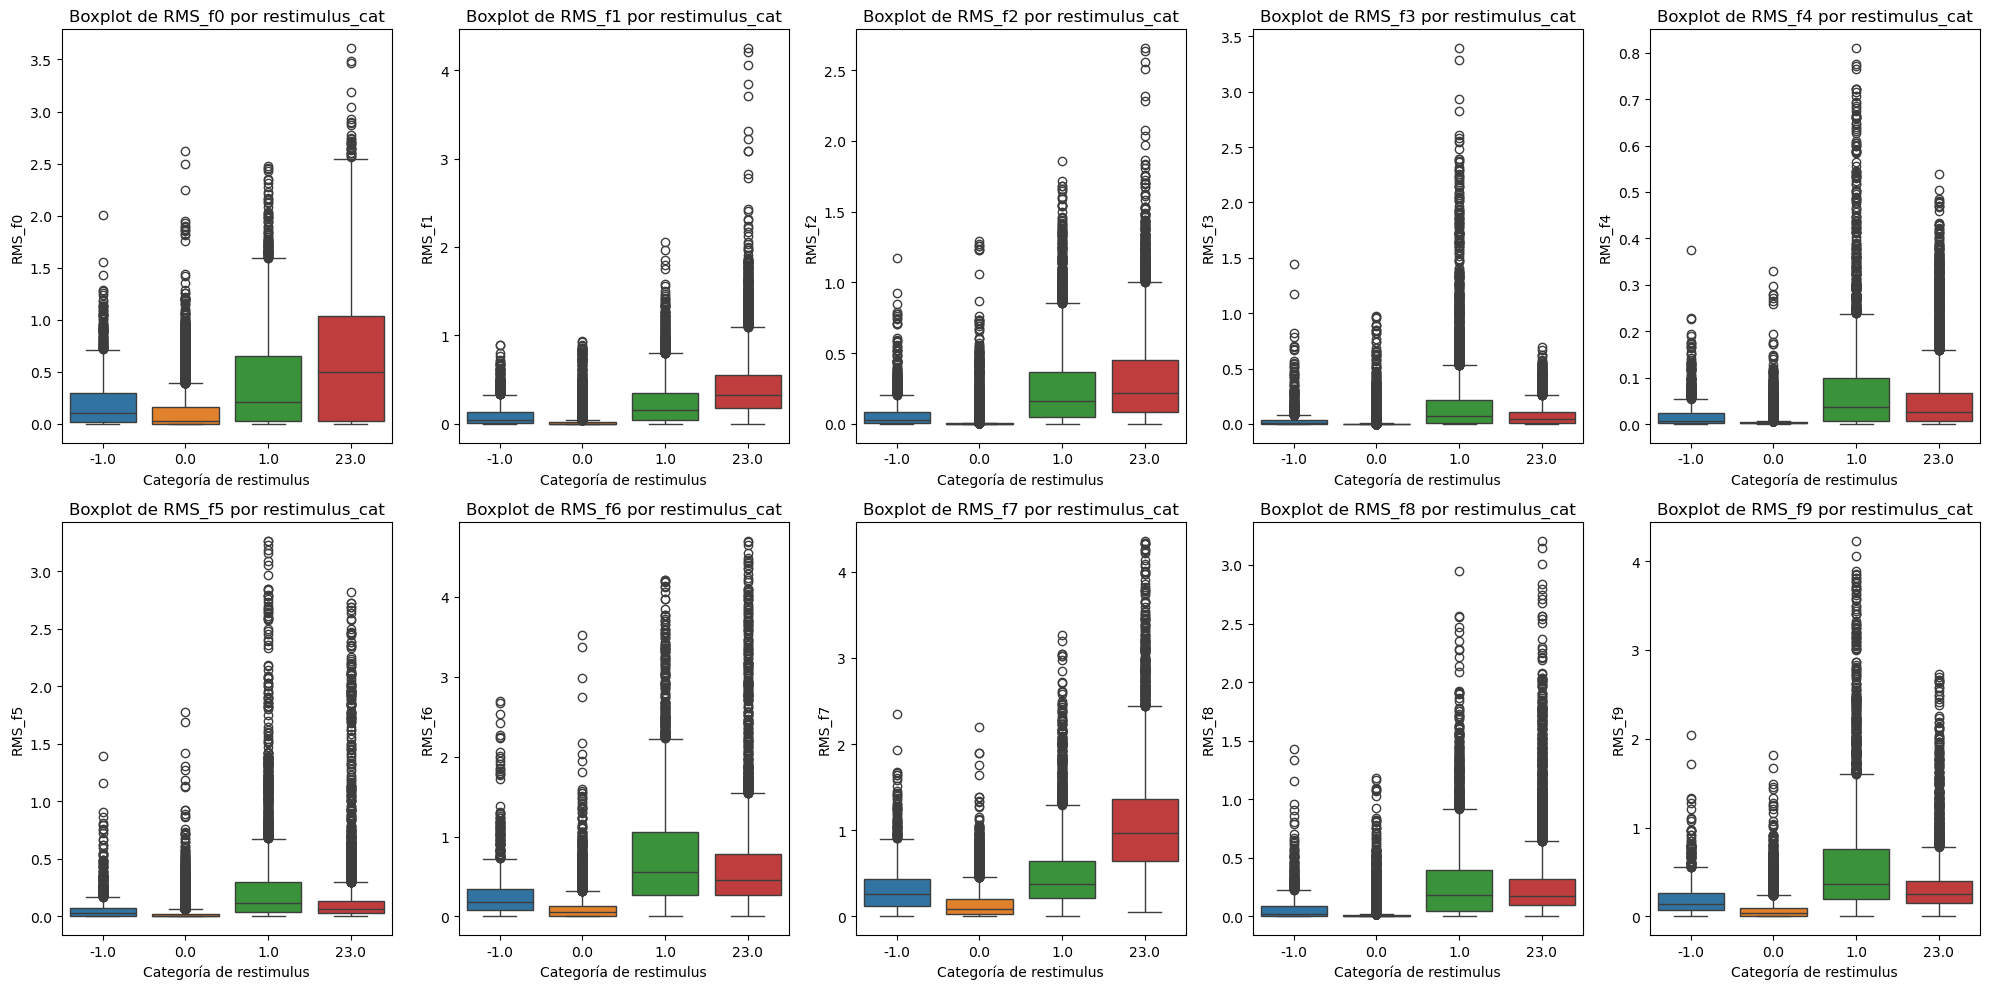

In [52]:
# Crear una figura y subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 2 filas y 5 columnas para 10 columnas en total
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar un boxplot para cada columna RMS con colores distintos por categoría
for i, col in enumerate(rms_columns):
    sns.boxplot(x='restimulus_cat', y=col, data=rms_df, ax=axes[i], hue='restimulus_cat', palette='tab10', dodge=False, legend=False)
    axes[i].set_title(f'Boxplot de {col} por restimulus_cat')
    axes[i].set_xlabel('Categoría de restimulus')
    axes[i].set_ylabel(col)

# Ajustar el diseño
plt.tight_layout()
plt.show()

**Categórico vs. Categórico**

* Tablas de contingencia

In [56]:
# Crear una tabla de contingencia entre 'restimulus_cat' y 'subject_cat'
contingency_table = pd.crosstab(rms_df['restimulus_cat'], rms_df['subject_cat'])

# Mostrar la tabla de contingencia
contingency_table.T

restimulus_cat,-1.0,0.0,1.0,23.0
subject_cat,,,,
1,60,312,187,242
2,53,361,176,208
3,62,376,152,207
4,60,405,169,165
5,58,324,185,240
6,56,376,163,207
7,62,392,147,196
8,58,360,168,216
9,58,343,173,231


La grafica anterior se ve mas clara como grafico (Matrix tap)

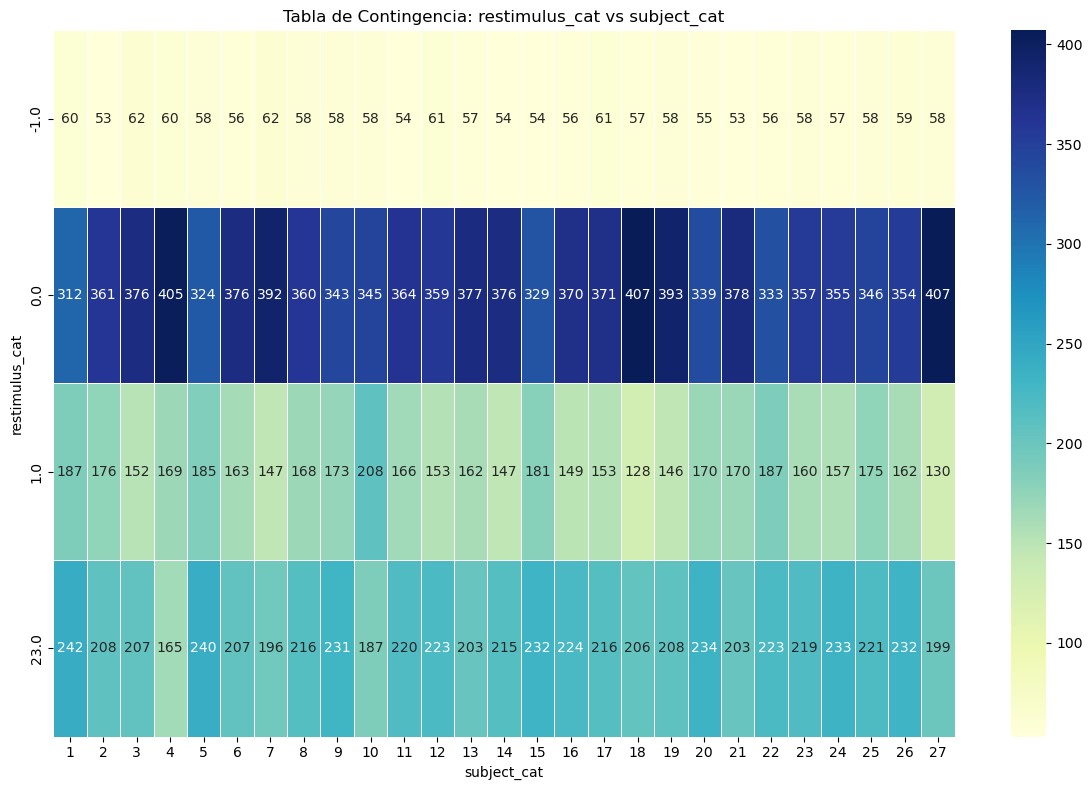

In [60]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_tab, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Tabla de Contingencia: restimulus_cat vs subject_cat")
plt.xlabel("subject_cat")
plt.ylabel("restimulus_cat")
plt.tight_layout()
plt.show()

* Graficos de barras apiladas

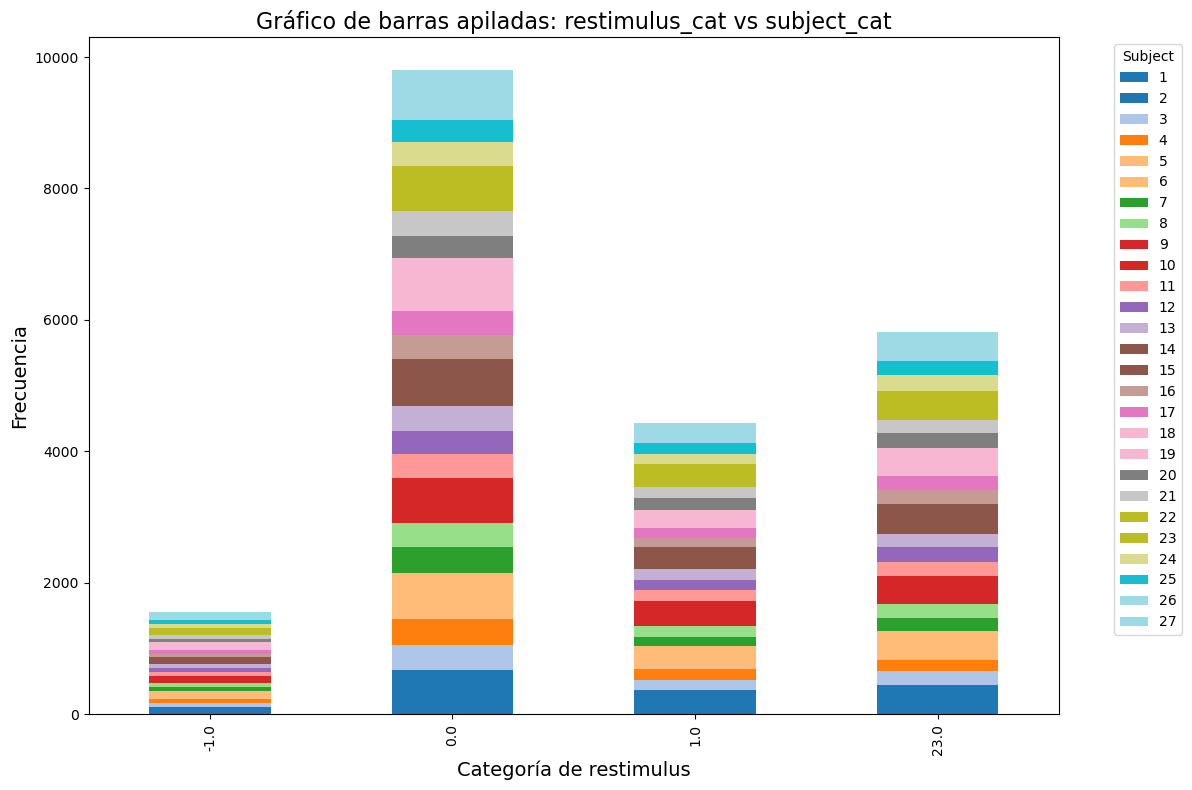

In [57]:
# Crear un gráfico de barras apiladas a partir de la tabla de contingencia
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

# Configurar el título y las etiquetas
plt.title('Gráfico de barras apiladas: restimulus_cat vs subject_cat', fontsize=16)
plt.xlabel('Categoría de restimulus', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Data frame Nuevo

### Pendiente

1. Generar DF completo
2. Drop a las features no usadas. Si vamos usar RMS, drop a MAV; ZC, SSC
3. * df_RMS Subject: rms_channel1, rms_channel2, ..., rms_channel3, grasp_label
     * Boxplots por canal
4. train-test split (80 - 20)
5. model fit:
   * SVM
   * KNN
   * CNN (Ultima a emplear)
   * RF 
6. Compare metrics:
   * Accuracy
   * ROC
   * F1 score
   * F2 score 

**Objetivo**: 
1. Hacer esto con MAV y RMS
2. Todas menos CNN


